In [35]:
import HiGHS
using DataFrames: DataFrame
using JuMP

axis(a) = axes(a, 1)
base_power = 1000

1000

In [36]:
# Network data
nodes = [
    (id=1, load=0, x=-1, y=1),
    (id=2, load=0, x=1, y=1),
    (id=3, load=150, x=0, y=0),
] |> DataFrame

Row,id,load,x,y
,Int64,Int64,Int64,Int64
1,1,0,-1,1
2,2,0,1,1
3,3,150,0,0


In [37]:
generators = [
    (id=1, node_id=1, capacity=200, cost=10),
    (id=2, node_id=2, capacity=200, cost=12),
    (id=3, node_id=1, capacity=200, cost=14),
] |> DataFrame

Row,id,node_id,capacity,cost
,Int64,Int64,Int64,Int64
1,1,1,200,10
2,2,2,200,12
3,3,1,200,14


In [38]:
lines = [
    (id=1, from_node_id=1, to_node_id=2, susceptance=0.25, capacity=30),
    (id=2, from_node_id=1, to_node_id=3, susceptance=0.25, capacity=300),
    (id=3, from_node_id=2, to_node_id=3, susceptance=0.25, capacity=300),
] |> DataFrame

Row,id,from_node_id,to_node_id,susceptance,capacity
,Int64,Int64,Int64,Float64,Int64
1,1,1,2,0.25,30
2,2,1,3,0.25,300
3,3,2,3,0.25,300


In [39]:
offers = [
    (id=1, generator_id=1, max_quantity=200, price=10),
    (id=2, generator_id=2, max_quantity=200, price=12),
    (id=3, generator_id=3, max_quantity=200, price=14),
] |> DataFrame

Row,id,generator_id,max_quantity,price
,Int64,Int64,Int64,Int64
1,1,1,200,10
2,2,2,200,12
3,3,3,200,14


In [40]:
node_line = [
    if node.id == line.from_node_id
        -1
    elseif node.id == line.to_node_id
        +1
    else
        0
    end
    for node = eachrow(nodes), line = eachrow(lines)
]


3×3 Matrix{Int64}:
 -1  -1   0
  1   0  -1
  0   1   1

In [41]:
node_generator_offer = [
    if node.id == generator.node_id && generator.id == offer.generator_id
        1
    else
        0
    end
    for node = eachrow(nodes), generator = eachrow(generators), offer = eachrow(offers)
]


3×3×3 Array{Int64, 3}:
[:, :, 1] =
 1  0  0
 0  0  0
 0  0  0

[:, :, 2] =
 0  0  0
 0  1  0
 0  0  0

[:, :, 3] =
 0  0  1
 0  0  0
 0  0  0

In [42]:
model = Model(HiGHS.Optimizer)

@variable(model, p[o=axis(offers)])
@variable(model, f[ℓ=axis(lines)])
@variable(model, θ[n=axis(nodes)])

3-element Vector{VariableRef}:
 θ[1]
 θ[2]
 θ[3]

In [43]:
@objective(model, Min, sum(offers[:, :price] .* p))

10 p[1] + 12 p[2] + 14 p[3]

In [44]:
@constraint(
    model,
    balance[n=axis(nodes)],
    sum(
        node_generator_offer[n, g, o] * p[o]
        for g = axis(generators)
        for o = axis(offers)
    ) +
    sum(node_line[n, ℓ] * f[ℓ] for ℓ = axis(lines))
    ==
    nodes[n, :load]
)

3-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 balance[1] : p[1] + p[3] - f[1] - f[2] == 0
 balance[2] : p[2] + f[1] - f[3] == 0
 balance[3] : f[2] + f[3] == 150

In [45]:
@constraint(
    model,
    flow[ℓ=axis(lines)],
    sum(base_power * node_line[n, ℓ] * θ[n] * lines[ℓ, :susceptance] for n = axis(nodes)) == f[ℓ]
)

3-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 flow[1] : -f[1] - 250 θ[1] + 250 θ[2] == 0
 flow[2] : -f[2] - 250 θ[1] + 250 θ[3] == 0
 flow[3] : -f[3] - 250 θ[2] + 250 θ[3] == 0

In [46]:
@constraint(model, offer_bounds[o=axis(offers)], 0 .≤ p[o] .≤ offers[o, :max_quantity])
@constraint(model, flow_bounds[ℓ=axis(lines)], -lines[ℓ, :capacity] ≤ f[ℓ] ≤ +lines[ℓ, :capacity])
@constraint(model, angle_bounds[n=axis(nodes)], -π ≤ θ[n] ≤ +π)
@constraint(model, reference_angle, θ[1] == 0)


reference_angle : θ[1] == 0

In [47]:
model

optimize!(model)


Running HiGHS 1.10.0 (git hash: fd8665394e): Copyright (c) 2025 HiGHS under MIT licence terms
LP   has 16 rows; 9 cols; 28 nonzeros
Coefficient ranges:
  Matrix [1e+00, 2e+02]
  Cost   [1e+01, 1e+01]
  Bound  [0e+00, 0e+00]
  RHS    [3e+00, 3e+02]
Presolving model
5 rows, 7 cols, 14 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-16); columns 0(-9); elements 0(-28) - Reduced to empty
Solving the original LP from the solution after postsolve
Model status        : Optimal
Objective value     :  1.5600000000e+03
Relative P-D gap    :  0.0000000000e+00
HiGHS run time      :          0.00


In [48]:
@show p_star = value.(p)
@show f_star = value.(f)
@show θ_star_deg = value.(θ) .* 180 / π
@show prices = dual.(balance)

p_star = value.(p) = [120.0, 30.0, -0.0]
f_star = value.(f) = [30.0, 90.0, 60.0]
θ_star_deg = (value.(θ) .* 180) / π = [-0.0, 6.875493541569878, 20.626480624709636]
prices = dual.(balance) = [10.0, 12.0, 11.0]


3-element Vector{Float64}:
 10.0
 12.0
 11.0

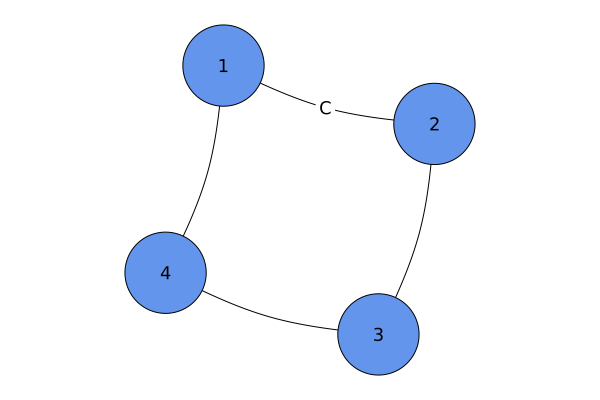

In [49]:
# notebook cell 1
using Graphs, Plots, GraphRecipes
gr()

g = Graph(4)
add_edge!(g, 1, 2)
add_edge!(g, 2, 3)
add_edge!(g, 3, 4)
add_edge!(g, 1, 4)

graphplot(g;
    names=1:nv(g),
    edgelabel=["A", "B", "C", "D"],
    method=:spring,
    nodeshape=:circle,
    nodesize=0.3,
    nodecolor=:cornflowerblue,
    fontsize=12)
